## This notebook focuses on the second part of the PatientOmics framework:

The aim is to organizing clinical time-series data for analysis and visualization, inwhich we perform the following tasks:

    1. We execute a script to generate the initial matrix containing clinical features for 116 patients, specifically on the first day of hospitalization.

    2. We visualize the correlation among laboratory features for potential long COVID patients (N = 116) on their first day of hospitalization, by:
        a. Grouping features based on their laboratory families.
        b. Sorting features by their average similarity distances.

    3. We create a cluster map to visualize data patterns among potential long COVID patients (N = 116).

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

## Get the clinical features for all patients at one time point (e.g. 1st day of hospitalization)

In [2]:
## Get the clinical features for all patients at one time point (e.g. 1st day of hospitalization)

import os
import pandas as pd

# Read the list of unique patient IDs
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
df = pd.read_csv(filename, sep=',', header=0)

# Initialize an empty list to store patient DataFrames
patient_dfs = []

## Set the day to be selected
days_col = 1  

# Iterate through the patient IDs
for patient_id in df['pseudoid_pid']:
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the CSV file into a DataFrame for each patient
        df_lab = pd.read_csv(filename, sep=',', header=0)

        # Get the row features for a specific day in 'days' column (e.g., 'days' == 0)
        df_lab_selected_day = df_lab[df_lab['days'] == days_col].copy()

        # Add a column 'patient_id' into the df_lab_selected_day
        df_lab_selected_day['patient_id'] = patient_id

        # Append the patient DataFrame to the list
        patient_dfs.append(df_lab_selected_day)

    except Exception as e:
    # except FileNotFoundError:
        print(f"Error reading patient {patient_id}: {str(e)}")
        continue

# Concatenate all patient DataFrames into one
collection_df = pd.concat(patient_dfs, ignore_index=True)

# Save the resulting DataFrame as a CSV file
output_csv_path = dir_path + '116_plcp_lab_markers_day-' + str(days_col) +'.csv'
collection_df.to_csv(output_csv_path, index=False)

Error reading patient 1001048: [Errno 2] No such file or directory: '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/patient_1001048.csv'


## Add data imputation for missing values (e.g., mean, median, mode, etc.) using sklearn.impute.SimpleImputer, according to the day before and after the missing value


In [6]:
# ## Add data imputation for missing values (e.g., mean, median, mode, etc.) using sklearn.impute.SimpleImputer, according to the day before and after the missing value

# import os
# import pandas as pd

# # Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# # Initialize an empty list to store patient DataFrames
# patient_dfs = []

# ## Set the day to be selected
# days_col = 1  

# # Iterate through the patient IDs
# for patient_id in df['pseudoid_pid']:
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

#     try:
#         # Read the CSV file into a DataFrame for each patient
#         df_lab = pd.read_csv(filename, sep=',', header=0)

#         # Get the row features for a specific day in 'days' column (e.g., 'days' == 0)
#         df_lab_selected_day = df_lab[df_lab['days'] == days_col].copy()

#         df_lab_day_before = df_lab[df_lab['days'] == days_col-1].copy()
#         df_lab_day_after = df_lab[df_lab['days'] == days_col+1].copy()

#         ## Add data imputation for missing values using sklearn.impute.SimpleImputer, according to the day before and after the missing value
#         df_lab_data_imputation =
        

#         # Append the patient DataFrame to the list
#         patient_dfs.append(df_lab_selected_day)

#     except Exception as e:
#     # except FileNotFoundError:
#         print(f"Error reading patient {patient_id}: {str(e)}")
#         continue

# # Concatenate all patient DataFrames into one
# collection_df = pd.concat(patient_dfs, ignore_index=True)

# # Save the resulting DataFrame as a CSV file
# output_csv_path = dir_path + '116_plcp_lab_markers_day-' + str(days_col) +'.csv'
# collection_df.to_csv(output_csv_path, index=False)

In [49]:
# import os
# import pandas as pd
# from sklearn.impute import SimpleImputer


# def impute_missing_values(df_lab_selected_day, df_lab_day_before, df_lab_day_after, columns_to_impute):
#     """Function for data imputation using sklearn.impute.SimpleImputer, according to the day before and after the missing value"""

#     for column in columns_to_impute:
#         # Find missing values for the selected day
#         missing_indices = df_lab_selected_day[column].isna()
        
#         # Impute missing values based on the day before and after
#         for index, value in enumerate(missing_indices):
#             if value:
#                 before_value = df_lab_day_before.iloc[index][column]
#                 after_value = df_lab_day_after.iloc[index][column]
#                 df_lab_selected_day.at[index, column] = imputer.fit_transform([[before_value, after_value]])[0, 0]

#     return df_lab_selected_day


# # Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# # Initialize an empty list to store patient DataFrames
# patient_dfs = []

# # Set the day to be selected
# selected_day = 0

# # Initialize SimpleImputer with your preferred strategy (e.g., 'mean', 'median', or 'most_frequent')
# imputer = SimpleImputer(strategy='mean') 


# # Iterate through the patient IDs
# for patient_id in df['pseudoid_pid']:
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

#     try:
#         ## Read the CSV file into a DataFrame for each patient
#         df_lab = pd.read_csv(filename, sep=',', header=0)

#         ## Get the row features for a specific day in 'days' column (e.g., 'days' == 0)
#         df_lab_day_selected = df_lab[df_lab['days'] == selected_day].copy()

#         ## Get the row features from 'df_lab' for the day following seven days after the selected day

#         ## Get the row features from 'df_lab' for the day before and after the selected day
#         df_lab_day_before = df_lab[df_lab['days'] == selected_day + 1].copy()
#         df_lab_day_after = df_lab[df_lab['days'] == selected_day + 2].copy()
        
        
#         ## Get the columns to impute from the dataframe df_lab_day_selected
#         columns_to_impute = df_lab_day_selected.columns[2:-1].tolist()
#         # columns_to_impute = ['ALAT', 'ASAT', 'Basophile', 'C-reaktives Protein', 'Eosinophile', 'Erythrozyten', 'G-Glutamyltransferase', 'Glucose', 'Hämatokrit', 'Hämoglobin', 'INR', 'Immature Granulozyten', 'Kalium', 'LDH nach IFCC', 'Lactat arteriell', 'Leukozyten', 'Lymphozyten', 'MCH', 'MCHC', 'MCV', 'Monozyten', 'Natrium', 'Neutrophile', 'Neutrophile Granulozyten', 'Normoblasten maschinell', 'RDW', 'Thrombozyten', 'eGFR nach CKD-EPI']
#         print('columns_to_impute: ', columns_to_impute)

#         ## Apply data imputation
#         df_lab_day_selected = impute_missing_values(df_lab_day_selected, df_lab_day_before, df_lab_day_after, columns_to_impute)

#         # Add a column 'patient_id' into the df_lab_selected_day
#         df_lab_day_selected['patient_id'] = patient_id

#         # Append the patient DataFrame to the list
#         patient_dfs.append(df_lab_day_selected)

#     except Exception as e:
#         print(f"Error reading patient {patient_id}: {str(e)}")
#         continue

# # Concatenate all patient DataFrames into one
# collection_df = pd.concat(patient_dfs, ignore_index=True)

# # Save the resulting DataFrame as a CSV file
# output_csv_path = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{days_col}.csv')
# collection_df.to_csv(output_csv_path, index=False)

In [60]:
# import os
# import pandas as pd
# from sklearn.impute import SimpleImputer

# def impute_missing_values(df_lab_selected_day, df_lab_day_after, columns_to_impute):
#     """Function for data imputation using sklearn.impute.SimpleImputer, based on the day after the missing value"""

#     for column in columns_to_impute:
#         # Find missing values for the selected day
#         missing_indices = df_lab_selected_day[column].isna()

#         # Impute missing values based on the day after
#         for index, value in enumerate(missing_indices):
#             if value:
#                 after_value = df_lab_day_after.iloc[index][column]
#                 df_lab_selected_day.at[index, column] = after_value

#     return df_lab_selected_day

# # Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# # Initialize an empty list to store patient DataFrames
# patient_dfs = []

# # Set the day to be selected
# selected_day = 10

# # Initialize SimpleImputer with your preferred strategy (e.g., 'mean', 'median', or 'most_frequent')
# imputer = SimpleImputer(strategy='mean')

# # Iterate through the patient IDs
# for patient_id in df['pseudoid_pid']:
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

#     try:
#         # Read the CSV file into a DataFrame for each patient
#         df_lab = pd.read_csv(filename, sep=',', header=0)

#         # Get the row features for a specific day in 'days' column (e.g., 'days' == 0)
#         df_lab_day_selected = df_lab[df_lab['days'] == selected_day].copy()

#         # Get the row features from 'df_lab' for the day following seven days after the selected day
#         df_lab_day_after = df_lab[df_lab['days'].between(selected_day + 1, selected_day + 7)].copy()

#         # Get the columns to impute from the dataframe df_lab_day_selected
#         columns_to_impute = df_lab_day_selected.columns[2:-1].tolist()
#         # print('columns_to impute:', columns_to_impute)

#         # Apply data imputation
#         df_lab_day_selected = impute_missing_values(df_lab_day_selected, df_lab_day_after, columns_to_impute)

#         # Add a column 'patient_id' into the df_lab_selected_day
#         df_lab_day_selected['patient_id'] = patient_id

#         # Append the patient DataFrame to the list
#         patient_dfs.append(df_lab_day_selected)

#     except Exception as e:
#         print(f"Error reading patient {patient_id}: {str(e)}")
#         continue

# # Concatenate all patient DataFrames into one
# collection_df = pd.concat(patient_dfs, ignore_index=True)

# # Save the resulting DataFrame as a CSV file
# output_csv_path = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{selected_day}.csv')
# collection_df.to_csv(output_csv_path, index=False)


Error reading patient 1000037: single positional indexer is out-of-bounds
Error reading patient 1000065: single positional indexer is out-of-bounds
Error reading patient 1000066: single positional indexer is out-of-bounds
Error reading patient 1000095: single positional indexer is out-of-bounds
Error reading patient 1000104: single positional indexer is out-of-bounds
Error reading patient 1000300: single positional indexer is out-of-bounds
Error reading patient 1000302: single positional indexer is out-of-bounds
Error reading patient 1000482: single positional indexer is out-of-bounds
Error reading patient 1000496: single positional indexer is out-of-bounds
Error reading patient 1000512: single positional indexer is out-of-bounds
Error reading patient 1000545: single positional indexer is out-of-bounds
Error reading patient 1000562: single positional indexer is out-of-bounds
Error reading patient 1000571: single positional indexer is out-of-bounds
Error reading patient 1000586: single 

In [65]:
import os
import pandas as pd
from sklearn.impute import SimpleImputer

def impute_missing_values(df_lab_selected_day, df_lab_days, columns_to_impute):
    """Function for data imputation using sklearn.impute.SimpleImputer, based on a range of days"""
    imputer = SimpleImputer(strategy='mean')
    
    for column in columns_to_impute:
        for index, row in df_lab_selected_day.iterrows():
            if pd.isna(row[column]):
                available_values = df_lab_days[df_lab_days['days'] == row['days'] + 1][column].tolist()
                if available_values:
                    imputed_value = imputer.fit_transform([available_values])[0, 0]
                    df_lab_selected_day.at[index, column] = imputed_value

    return df_lab_selected_day

# Read the list of unique patient IDs
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
df = pd.read_csv(filename, sep=',', header=0)

# Initialize an empty list to store patient DataFrames
patient_dfs = []

# Set the day range to be selected
# init_day = 0
# end_day = 7

init_day = 8
end_day = 15

# Iterate through the patient IDs
for patient_id in df['pseudoid_pid']:
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the CSV file into a DataFrame for each patient
        df_lab = pd.read_csv(filename, sep=',', header=0)

        # Get the row features from 'df_lab' for the selected day range
        df_lab_days = df_lab[df_lab['days'].between(init_day, end_day)].copy()

        # Get the columns to impute from the dataframe df_lab_days
        columns_to_impute = df_lab_days.columns[2:-1].tolist()

        # Iterate through the selected days
        for selected_day in range(init_day, end_day + 1):
            # Get the row features for a specific day in 'days' column
            df_lab_day_selected = df_lab_days[df_lab_days['days'] == selected_day].copy()

            # Apply data imputation for the selected day
            df_lab_day_selected = impute_missing_values(df_lab_day_selected, df_lab_days, columns_to_impute)

            # Add a column 'patient_id' into the df_lab_day_selected
            df_lab_day_selected['patient_id'] = patient_id

            # Append the patient DataFrame to the list
            patient_dfs.append(df_lab_day_selected)

    except Exception as e:
        print(f"Error reading patient {patient_id}: {str(e)}")
        continue

# Concatenate all patient DataFrames into one
collection_df = pd.concat(patient_dfs, ignore_index=True)

# Save the resulting DataFrame as a CSV file
output_csv_path = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{init_day}_to_{end_day}.csv')
collection_df.to_csv(output_csv_path, index=False)

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='

Error reading patient 1000037: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000065: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000066: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000095: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000104: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000115: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000151: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000187: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000294: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000300: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000302: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000324: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000351: index 0 is out of bou

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='

Error reading patient 1000496: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000512: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000545: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000562: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000571: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000586: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000596: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000601: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000635: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000662: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000711: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000731: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000740: index 0 is out of bou

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='

Error reading patient 1000944: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000998: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001018: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001054: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001110: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001112: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001122: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001157: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001161: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001235: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001261: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001272: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001288: index 0 is out of bou

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='

Error reading patient 1000186: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000213: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000241: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000245: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000289: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000301: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000372: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000394: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000397: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000457: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000535: index 0 is out of bounds for axis 1 with size 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='

Error reading patient 1000608: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000626: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000692: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000738: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000758: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000766: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000783: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000822: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000949: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000968: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000974: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000985: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1000986: index 0 is out of bou

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='

Error reading patient 1001108: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001135: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001214: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001217: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001260: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001269: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001343: index 0 is out of bounds for axis 1 with size 0
Error reading patient 1001362: index 0 is out of bounds for axis 1 with size 0


### Grouped features based on their laboratory family

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


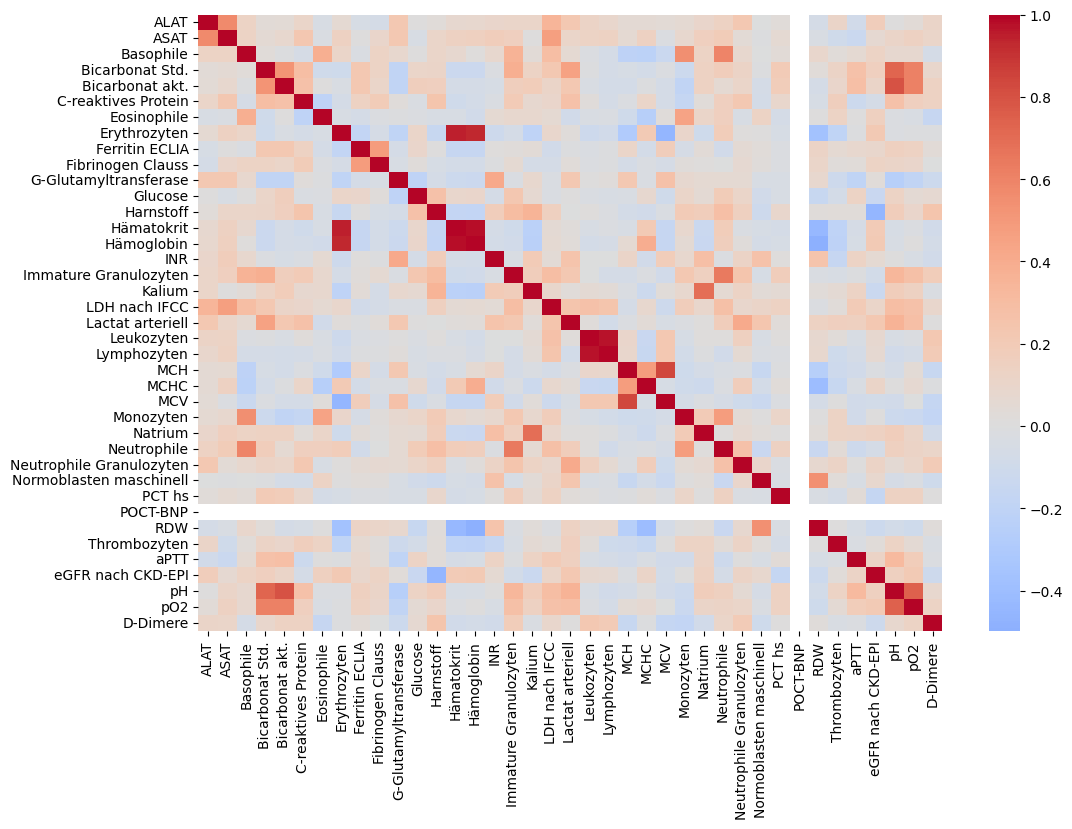

In [62]:
### Grouped features based on their laboratory family

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, 'lab_data_exploration.csv')
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{days_col}.csv')

df = pd.read_csv(filename, sep=',', header=0, index_col=0)

## Set NaN values to 0
df = df.fillna(0)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data, metric='euclidean')

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)

plt.show()

### Sort features based on their average similarity distances

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

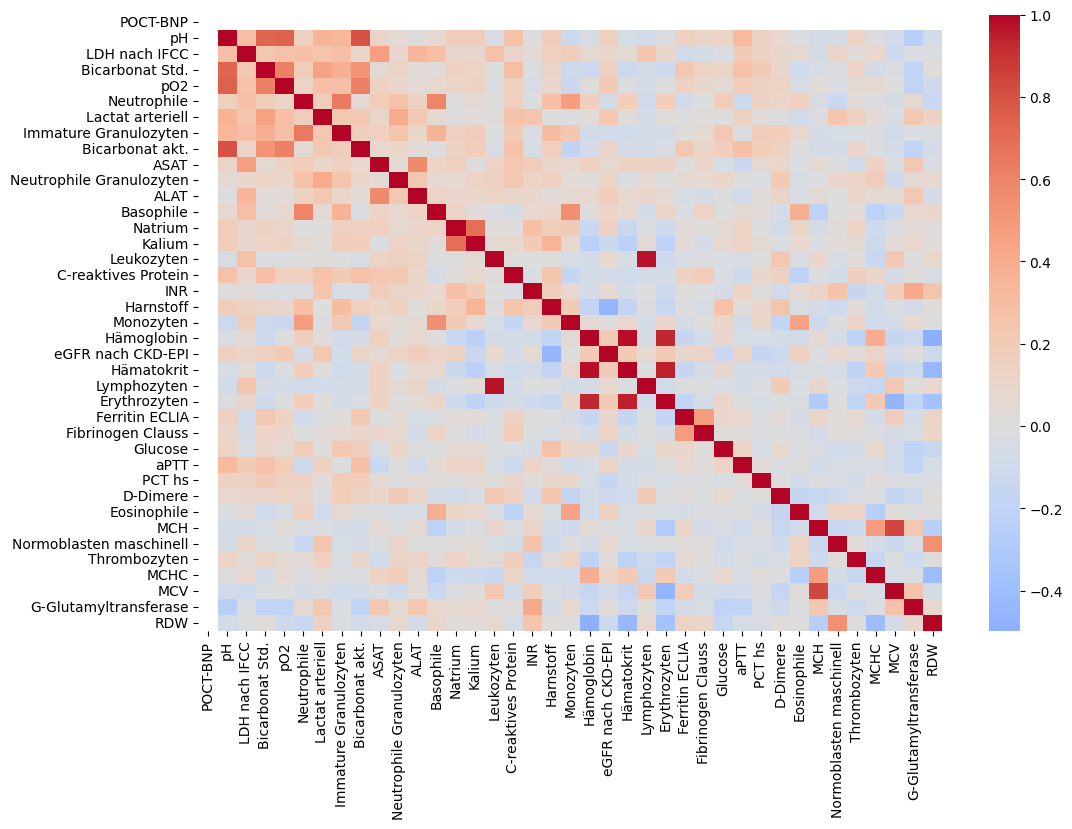

In [63]:
### Sort features based on their average similarity distances

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, 'lab_data_exploration.csv')
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{days_col}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

## Set NaN values to 0
df = df.fillna(0)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data.T, metric='euclidean')  # Transpose to get feature distances

# Calculate average similarity distance for each feature
average_distances = np.mean(similarities, axis=0)

# Sort features based on their average similarity distances
sorted_indices = np.argsort(average_distances)
sorted_features = df.columns[sorted_indices]

# Reorder the dataframe columns based on sorted features
sorted_df = df[sorted_features]

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = sorted_df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)


## Cluster map to visualize data patterns among potential long COVID patients (N = 116)

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=sel

<Figure size 1500x1000 with 0 Axes>

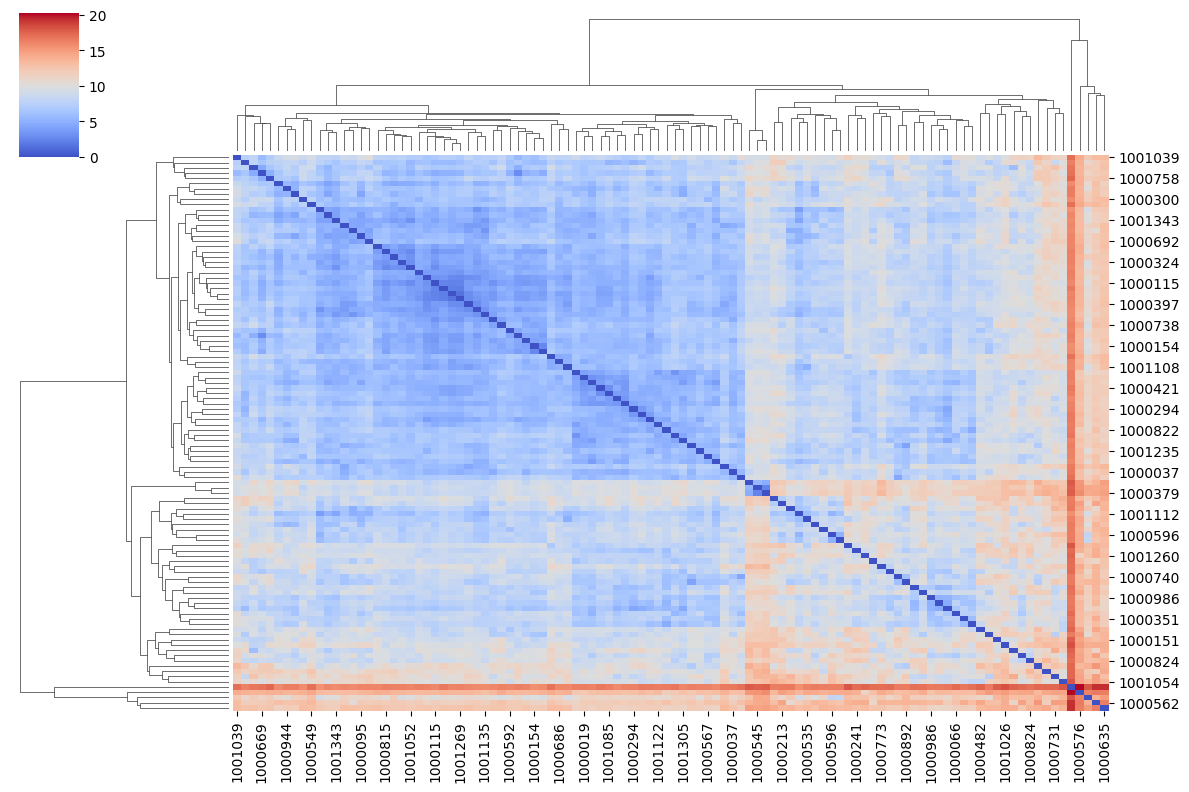

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, 'lab_data_exploration.csv')
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{days_col}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

## Set NaN values to 0
df = df.fillna(0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(12, 8), center=10)

plt.show()

## Computing the PCA to visualize data patterns among potential long COVID patients (N = 116)

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

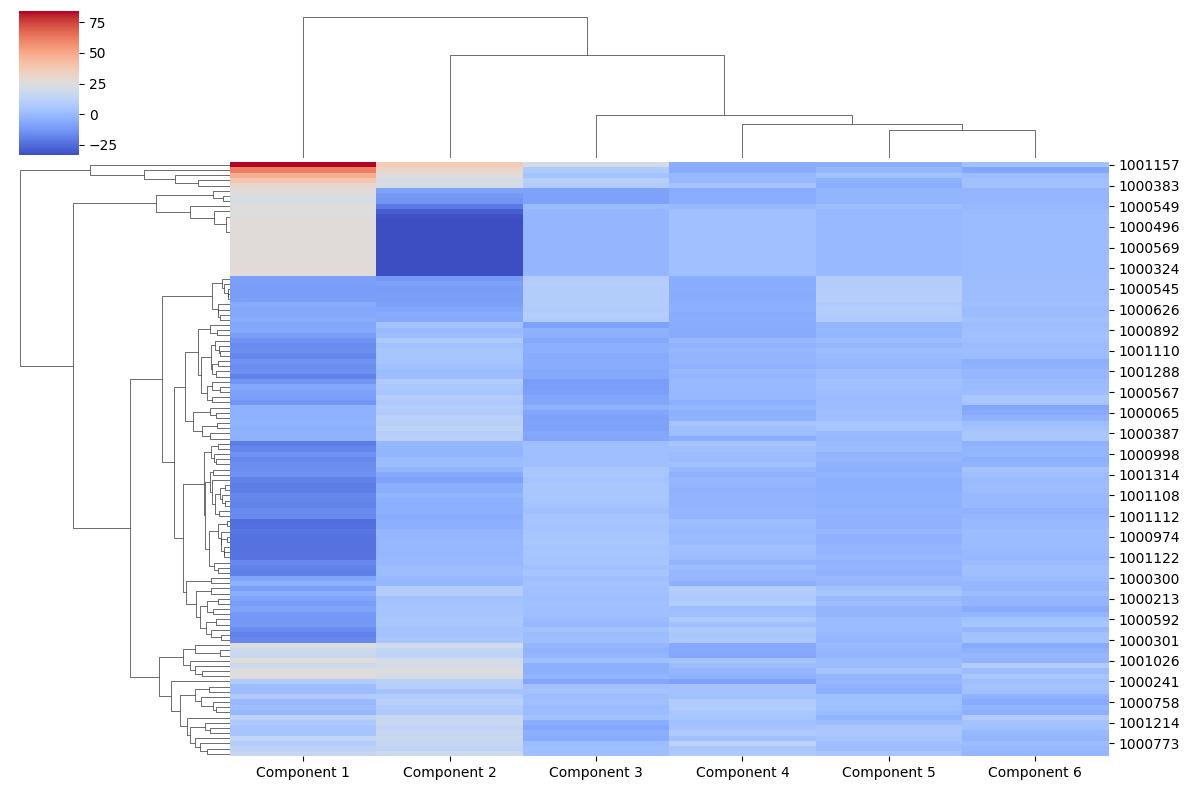

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=6, random_state=seed)  # Using 6 components
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=[f'Component {i+1}' for i in range(6)], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
# sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

## Stablish 0 as the center of the heatmap
sns.clustermap(mds_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(12, 8), center=25)

plt.show()

/tmp/ipykernel_40900/1962119126.py:33: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')
/tmp/ipykernel_40900/1962119126.py:53: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')


<Figure size 1500x1000 with 0 Axes>

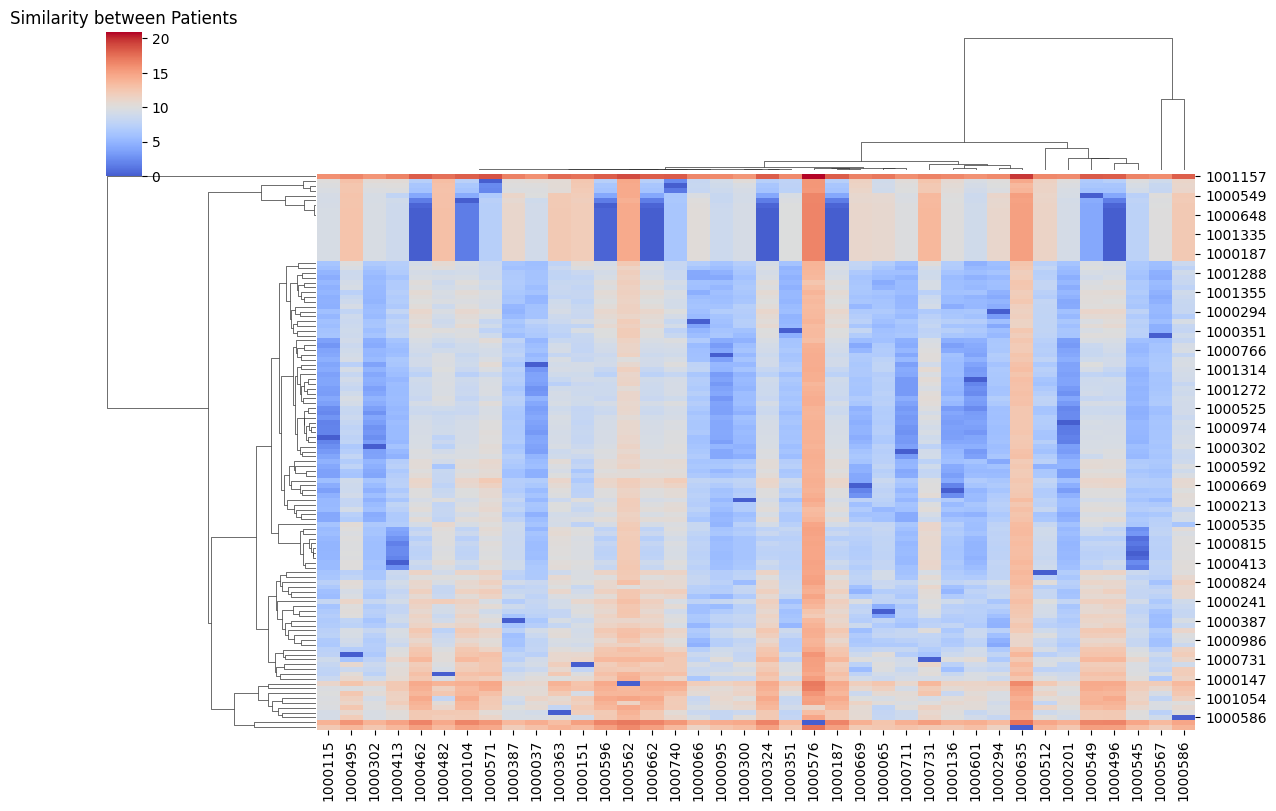

Sorted Feature Names: Index(['Hämatokrit', 'Monozyten', 'Normoblasten maschinell',
       'Immature Granulozyten', 'Basophile', 'Eosinophile', 'Lactat arteriell',
       'INR', 'Neutrophile Granulozyten', 'pH', 'Neutrophile', 'Erythrozyten',
       'Kalium', 'PCT hs', 'Harnstoff', 'Glucose', 'Bicarbonat Std.',
       'Bicarbonat akt.', 'RDW', 'Leukozyten', 'Lymphozyten', 'aPTT', 'MCH',
       'ALAT', 'pO2', 'ASAT', 'G-Glutamyltransferase', 'Hämoglobin', 'Natrium',
       'MCV', 'eGFR', 'Ferritin', 'MCHC', 'Lactat-Dehydrogenase',
       'Thrombozyten', 'LDH', 'Fibrinogen Clauss', 'D-Dimere'],
      dtype='object')


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Calculate linkage for hierarchical clustering of patients
patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')

# Get the order of patients based on the clustering
patient_order = hierarchy.leaves_list(patient_linkage)

# Sort patient IDs according to the clustering order
sorted_patient_ids = patient_ids[patient_order]

# Create a DataFrame with the similarities and sorted patient IDs
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Calculate the similarity matrix for features
feature_similarities = euclidean_distances(samples.T)

# Replace NaN with infinity
feature_similarities[np.isnan(feature_similarities)] = np.inf

# Calculate linkage for hierarchical clustering of features
feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')

# Get the order of features based on the clustering
feature_order = hierarchy.leaves_list(feature_linkage)

# Sort feature names according to the clustering order
sorted_feature_names = feature_names[feature_order]

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='coolwarm', row_cluster=True, col_cluster=True, center=10,
               row_linkage=patient_linkage, col_linkage=feature_linkage,
               figsize=(12, 8), cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Add sorted feature names to the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Similarity between Patients")

# Show the plot
plt.show()

# Display sorted feature names
print("Sorted Feature Names:", sorted_feature_names)